In [1]:
import data_collection
import data_processing
import pandas as pd
import re
from sqlalchemy import create_engine, insert, select, func, update
from sqlalchemy import MetaData, Table, Column, Integer, String, Date, Text, ForeignKey, JSON
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.orm import Session, aliased
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

## PHASE 1: Collecting the data

* Extract drug details from dailyMed API

In [2]:
drugs_data = data_collection.fetch_dailyMed_data("drugclasses")
drugs_data = pd.DataFrame(drugs_data.get('data', []))[["type", "name"]]
drugs_data = data_processing.clean_data(drugs_data, remove_duplicates=True)

* Extract recalls and adverse events of drug from OpenFDA

In [3]:
adverse_events_data = data_collection.fetch_openfda_data("event", {"limit": 10})
adverse_events_data = pd.DataFrame(adverse_events_data.get('results', []))[["receivedate","sender", "receiver", "patient", "reportduplicate" , "occurcountry"]]
adverse_events_data = data_processing.clean_data(adverse_events_data)
adverse_events_data['occurcountry'] = adverse_events_data['occurcountry'].replace({"us": "united states"})

recalls_data = data_collection.fetch_openfda_data("enforcement", {"limit": 10})
recalls_data = pd.DataFrame(recalls_data.get('results', []))[["reason_for_recall", "recall_initiation_date",  "country"]]
recalls_data = data_processing.clean_data(recalls_data)

* Visualize the distribution of data

               *** Drug details table ***
   type                                          name
0   epc  4hydroxyphenylpyruvate dioxygenase inhibitor
1   epc                    5alpha reductase inhibitor
2   epc                       5lipoxygenase inhibitor
3   epc               acetylcholine release inhibitor
4   epc                                   actinomycin
..  ...                                           ...
95  epc                       beta2adrenergic agonist
96  epc                       beta3adrenergic agonist
97  epc                                     biguanide
98  epc                                     bile acid
99  epc                         bile acid sequestrant

[94 rows x 2 columns]


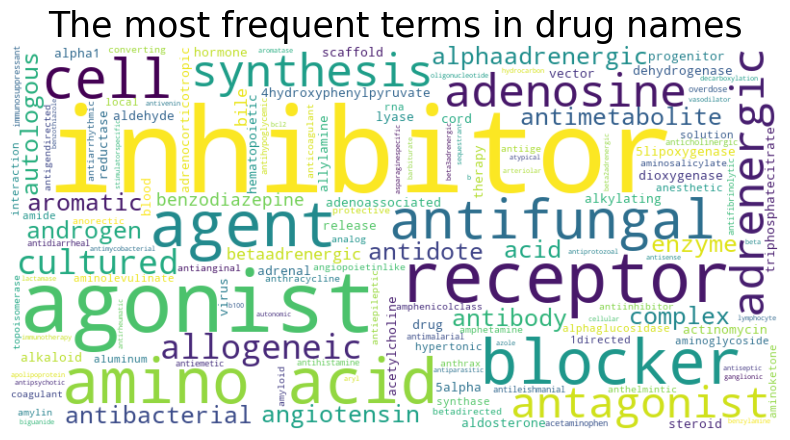

In [4]:
print("               *** Drug details table ***")
print(drugs_data)
text = " ".join(drugs_data["name"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("The most frequent terms in drug names", size = 25)
plt.axis('off')
plt.show()

In [13]:
print("               *** Drug adverse events table ***")
print(adverse_events_data)

country_counts = adverse_events_data["occurcountry"].value_counts().reset_index()
country_counts.columns = ["Country", "Adverse Event Count"]

fig = px.choropleth(
    country_counts,
    locations="Country",
    locationmode="country names",
    color="Adverse Event Count",
    title="Geographical Distribution of Adverse Events"
)
fig.show()

               *** Drug adverse events table ***
  receivedate                                         sender  \
0    20080707               senderorganization fdapublic use   
1    20140306  sendertype 2 senderorganization fdapublic use   
2    20140228  sendertype 2 senderorganization fdapublic use   
3    20140312  sendertype 2 senderorganization fdapublic use   
4    20140312  sendertype 2 senderorganization fdapublic use   
5    20140312  sendertype 2 senderorganization fdapublic use   
6    20140312  sendertype 2 senderorganization fdapublic use   
7    20140312  sendertype 2 senderorganization fdapublic use   
8    20140312  sendertype 2 senderorganization fdapublic use   
9    20140312  sendertype 2 senderorganization fdapublic use   

                                  receiver  \
0                                     none   
1  receivertype 6 receiverorganization fda   
2  receivertype 6 receiverorganization fda   
3  receivertype 6 receiverorganization fda   
4  receivertype 

                  *** Drug recalls table ***
                                   reason_for_recall recall_initiation_date  \
0  lack of assurance of sterility  a recall of al...             2015-09-03   
1  cgmp deviations next advanced antibacterial ha...             2020-07-30   
2  some bottles may contain mixed strengths of th...             2020-05-22   
3  cgmp deviations products were manufactured wit...             2021-10-26   
4  presence of particulate matter api contaminate...             2016-05-05   
5  labeling incorrect or missing lot and or exp d...             2014-07-08   
6                                    cgmp deviations             2024-06-20   
7                     lack of assurance of sterility             2018-09-10   
8  temperature abuse certain vials of ifosfamide ...             2013-09-13   
9  labeling label mix up cartons labeled as amant...             2017-06-19   

         country  
0  united states  
1         mexico  
2  united states  
3  united

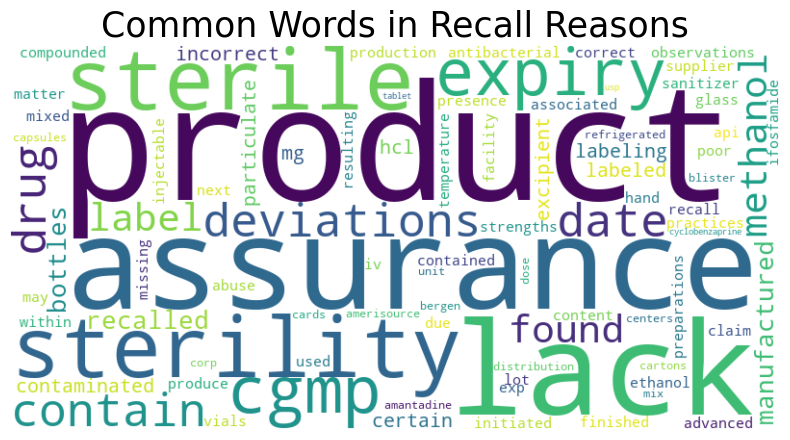

In [23]:
print("                  *** Drug recalls table ***")
print(recalls_data)

text = " ".join(recalls_data["reason_for_recall"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Words in Recall Reasons", size = "25")
plt.show()



## PHASE 2: Processing the data

* Connect Python to the SQL Database

In [7]:
try:
    engine = data_processing.get_connection()
    print(
        f"Connection created successfully!", "\n")
except Exception as ex:
    print("Connection could not be made due to the following error: \n", ex)

Connection created successfully! 



* Create Tables from Schema in Python

In [8]:
meta, drugs, recalls, adverse_events = data_processing.create_tables(engine) 

Tables created successfully! 



* Insert Cleaned Data from Python into SQL Tables

In [9]:
print("Inserting drug ingredients...", "\n")
data_processing.insert_cleaned_data_into_table(drugs, drugs_data, engine)


print("Inserting adverse events...", "\n")
data_processing.insert_cleaned_data_into_table(adverse_events, adverse_events_data, engine)

print("Inserting drug recalls...", "\n")
data_processing.insert_cleaned_data_into_table(recalls, recalls_data, engine)

print("All tables are inserted data successfully! \n")

Inserting drug ingredients... 

Inserting adverse events... 

Inserting drug recalls... 

All tables are inserted data successfully! 



* Query and Verify Data in SQL

In [33]:
print("Example of querying and verifying data in SQL: select the drug recall's reason and date from Mexico \n")
stmt1 = select(recalls.c.reason_for_recall, recalls.c.recall_initiation_date).where(recalls.c.country == "mexico").distinct()

with engine.begin() as conn:
    results = conn.execute(stmt1).fetchall()
    for row in results:
        print(row)

Example of querying and verifying data in SQL: select the drug recall's reason and date from Mexico 

('cgmp deviations next advanced antibacterial hand sanitizer was found to be below the label claim for ethanol content and contained methanol other products were recalled because they were manufactured in the same facility as the product found to contain methanol', datetime.date(2020, 7, 30))


In [34]:
print(pd.read_sql(stmt1, engine))

                                   reason_for_recall recall_initiation_date
0  cgmp deviations next advanced antibacterial ha...             2020-07-30


* Build Aggregated Queries

In [28]:
print("\nExample of aggregating queries: return the number of adverse events, and latest recall date of each country \n")
stmt = (
select(
    adverse_events.c.occurcountry.label("Country"),
    func.count(adverse_events.c.event_id.distinct()).label("AdverseEventCount"),
    func.max(recalls.c.recall_initiation_date).label("LatestRecallDate"),
    )
.select_from(adverse_events.join(recalls, adverse_events.c.occurcountry == recalls.c.country))
.group_by(adverse_events.c.occurcountry)
)

with engine.connect() as conn:
    results = conn.execute(stmt).fetchall()
    for row in results:
        print(row)


Example of aggregating queries: return the number of adverse events, and latest recall date of each country 

('united states', 70, datetime.date(2024, 6, 20))


In [29]:
chosen_layer_df = pd.read_sql(stmt, engine)
print("\n", chosen_layer_df)


          Country  AdverseEventCount LatestRecallDate
0  united states                 70       2024-06-20
